In [ ]:
from torchvision.models import resnet50
from PIL import Image
import torch
from torch import nn
import sys

sys.path.append('..')


import torch.nn.functional as F

from torchvision.transforms import Resize, Compose, ToTensor, Normalize

sample_x = Image.open('sample_data/example.png')

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
])

sample_x = transform(sample_x).unsqueeze(0).cuda()

sample_y = torch.tensor([249]).long().cuda()

model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    resnet50(pretrained=True)
).eval().cuda()

c:\Users\Zhangjiayu\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Zhangjiayu\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# before peforimg any attack, We need to define the loss function
# loss function takes only one argument, which is the batch of data
# We can define the loss function as follows
def loss_fn(batch):
    x, y = batch
    logits = model(x)
    return F.cross_entropy(logits, y)

# Or we can define the loss function like this
def loss_fn(model,batch):
    x, y = batch
    logits = model(x)
    return F.cross_entropy(logits, y)

from functools import partial
loss_fn = partial(loss_fn, model) # now loss_fn takes only one argument

#### Attack

In [23]:
from abe.algorithm.attack import FGSM, PGD, BIM, CW, MIFGSM, TIFGSM, DIFGSM, SINIFGSM, NAA, SSA, AdvGAN

In [ ]:
# first we need to define the attack task
from abe.task import AttackTask
from abe.type import ModelType

task = AttackTask(loss_fn=loss_fn, model_type=ModelType.IMAGECLASSIFICATION, is_targeted=False) # for targeted attack, set is_targeted=True

# then we can define the attack algorithm

attack = BIM(task) # BIM attack

adversarial_x = attack([sample_x, sample_y]) # all attack algorithms take a batch of data as input

targeted_task = AttackTask(loss_fn=loss_fn, model_type=ModelType.IMAGECLASSIFICATION, is_targeted=True)

targeted_attack = BIM(targeted_task)

targeted_adversarial_x = targeted_attack([sample_x, torch.zeros_like(sample_y)]) # for targeted attack, the second element of the batch should be the target label

In [25]:
# Now we can plot the adversarial example

from abe.metric.visualization import plot_adversarial_sample

<Figure size 640x480 with 0 Axes>

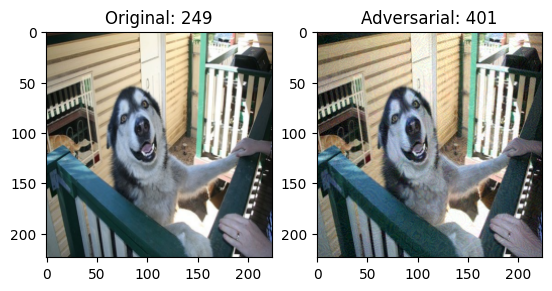

In [26]:
# To plot the adversarial example, we need to provide the original sample and the adversarial sample and forward function

def forward(batch):
    x, _ = batch
    return model(x)

plot_adversarial_sample(forward,batch=[sample_x,sample_y],adversarial_sample=adversarial_x,model_type=ModelType.IMAGECLASSIFICATION)

<Figure size 640x480 with 0 Axes>

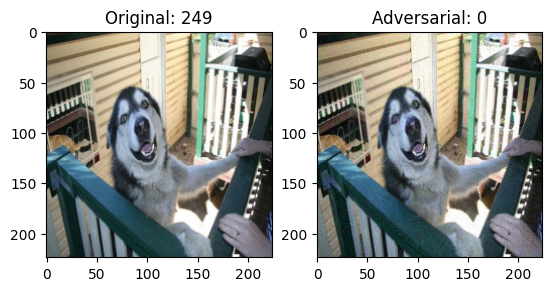

In [ ]:
plot_adversarial_sample(forward,batch=[sample_x,sample_y],adversarial_sample=targeted_adversarial_x,model_type=ModelType.IMAGECLASSIFICATION) # for targeted

#### Explanation

In [ ]:
from abe.algorithm.explanation import AMPE,IG, FastIG, SaliencyMap, SmoothGradient, BIG, MFABA, AGI, LA

In [35]:
# first we need to define the explanation task
from abe.task import ExplanationTask

# Explanation task takes loss function and forward function as initialization arguments

def loss_fn(batch):
    x, y = batch
    logits = model(x)
    loss = -torch.diag(logits[:, y]).sum()
    return loss

def forward(batch):
    x, _ = batch
    return model(x)

In [36]:
explanation_task = ExplanationTask(loss_fn=loss_fn, forward_fn=forward, model_type=ModelType.IMAGECLASSIFICATION)

In [43]:
# then we can define the explanation algorithm

explanation = AMPE(explanation_task)

attribution = explanation([sample_x, sample_y])

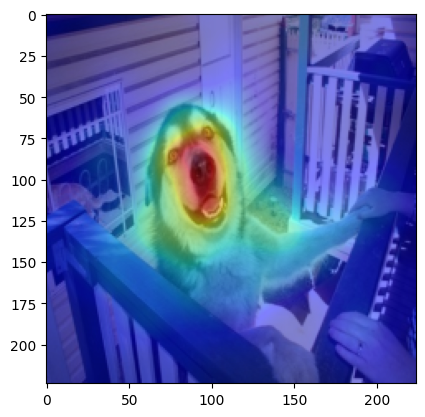

In [44]:
# Now we can plot the attribution map

from abe.metric.visualization import plot_explanation_heatmap

plot_explanation_heatmap(attribution, sample_x)